<a href="https://colab.research.google.com/github/pdoren/Machine-Learning-G105/blob/main/Desaf%C3%ADo_5_Prediciendo_los_precios_de_las_casas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Desafío 5 - Prediciendo los precios de las casas

**Nombre**: Pablo Saavedra <br />
**Curso**: Machine Learning (G105)


---

### Importación de librerías

In [1]:
from __future__ import annotations

# --- Standard library ---
from typing import Any, Dict, Iterable, Optional

# --- Third-party ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    classification_report,
    confusion_matrix,
    precision_recall_fscore_support,
    matthews_corrcoef,
    roc_auc_score,
    average_precision_score,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    PrecisionRecallDisplay,
)
from sklearn.model_selection import (
    GridSearchCV,
    StratifiedKFold,
    cross_val_predict,
    cross_val_score,
    train_test_split,
)

import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --- Pandas display options ---
pd.options.display.float_format = "{:,.2f}".format


### Funciones útiles

In [2]:
def plot_hist(_df: pd.DataFrame, _num_cols: list, _n_cols: int = 3, _bins='auto'):
  total = len(_num_cols)
  n_rows = int(np.ceil(total / _n_cols))

  fig, axes = plt.subplots(n_rows, _n_cols, figsize=(5*_n_cols, 4*n_rows))
  axes = axes.flatten()  # Para iterar fácil

  for i, col in enumerate(_num_cols):
      sns.histplot(data=_df[col], kde=False, stat='density', ax=axes[i], bins=_bins)
      sns.kdeplot(data=_df[col], color='tomato', lw=3, ax=axes[i])
      axes[i].set_title(f"Distribución de {col}")

  # Eliminar ejes vacíos si sobran
  for j in range(i+1, len(axes)):
      fig.delaxes(axes[j])

  plt.tight_layout()
  plt.show()

def plot_outliers(_df: pd.DataFrame, _num_cols: list, _n_cols: int = 3):
  total = len(_num_cols)
  n_rows = int(np.ceil(total / _n_cols))

  fig, axes = plt.subplots(n_rows, _n_cols, figsize=(5*_n_cols, 4*n_rows))

  if isinstance(axes, np.ndarray):
      axes = axes.ravel()
  else:
      axes = np.array([axes])

  for i, col in enumerate(_num_cols):
      sns.boxplot(x=_df[col], flierprops = {'markerfacecolor':'tomato', 'marker':'D'}, ax=axes[i])
      axes[i].set_title(f"Outliers en {col}")
      axes[i].set_xlabel(col)

  # Eliminar ejes vacíos si sobran
  for j in range(i+1, len(axes)):
      fig.delaxes(axes[j])

  plt.tight_layout()
  plt.show()


def clean_outliers(_df: pd.DataFrame, _cols: list, _k: float=1.5):
  df_ret = _df.copy()
  for col in _cols:
    while True:
      q1, q3 = df_ret[col].quantile([.25, .75])
      iqr = q3 - q1
      low, high = q1 - _k * iqr, q3 + _k * iqr
      mask_out = (df_ret[col] < low) | (df_ret[col] > high)
      if mask_out.any():
        df_ret = df_ret[~mask_out]
      else:
        break
  return df_ret

def clean_outliers_percentiles(
    _df: pd.DataFrame,
    _cols: list,
    p_low: float = 1,     # percentil inferior
    p_high: float = 99    # percentil superior
):

    df_ret = _df.copy()

    for col in _cols:
        # Calcular umbrales por percentiles
        low = df_ret[col].quantile(p_low / 100)
        high = df_ret[col].quantile(p_high / 100)

        # Crear máscara de puntos válidos
        mask = (df_ret[col] >= low) & (df_ret[col] <= high)

        # Filtrar el DataFrame
        df_ret = df_ret[mask]

    return df_ret

def plot_count(_df: pd.DataFrame, _num_cols: list, _n_cols: int = 3, _X:str=None):
  total = len(_num_cols)
  n_rows = int(np.ceil(total / _n_cols))

  fig, axes = plt.subplots(n_rows, _n_cols, figsize=(5*_n_cols, 4*n_rows))
  axes = axes.flatten()  # Para iterar fácil

  if _X is not None:
    for i, col in enumerate(_num_cols):
        sns.countplot(x=_X, data=_df, ax=axes[i], hue=str(col))
        axes[i].set_title(f"Frecuencia de {col}")
  else:
    for i, col in enumerate(_num_cols):
        sns.countplot(y=col, data=_df, order=_df[col].value_counts().index, ax=axes[i], hue=str(col))
        axes[i].set_title(f"Frecuencia de {col}")

  # Eliminar ejes vacíos si sobran
  for j in range(i+1, len(axes)):
      fig.delaxes(axes[j])

  plt.tight_layout()
  plt.show()


def eval_model(
  model,
  X_train, y_train,
  X_test,  y_test,
  class_names: Optional[Iterable[str]] = None,
  *,
  normalize_cm: str | None = "true",   # "true" | "pred" | "all" | None
  average: str = "weighted",           # "macro" | "weighted" | "micro"
  plot: bool = True,
  title_prefix: str = "",
  binary_threshold: Optional[float] = None,  # si None y hay proba, usa 0.5
  zero_division: int = 0,
  label_map: Optional[Dict[Any, int]] = None # parche: {'No':0,'Yes':1}, etc.
) -> Dict[str, Any]:
  """
  Evalúa un clasificador en train/test con métricas y (opcional) gráficos.
  Incluye parche para alinear tipos de etiqueta (p. ej., y_true en str y y_pred en int).
  Retorna un diccionario con métricas.

  Parámetros clave:
  - class_names: etiquetas para los ejes de las matrices de confusión.
  - label_map: mapeo explícito de etiquetas reales -> enteros del modelo.
  - binary_threshold: umbral de decisión si el modelo expone predict_proba/decision_function.
  """
  # ---------------------------
  # 0) Parche de etiquetas
  # ---------------------------
  y_train = np.asarray(y_train)
  y_test  = np.asarray(y_test)

  # ¿El modelo genera probabilidades / scores?
  has_proba    = hasattr(model, "predict_proba")
  has_decision = hasattr(model, "decision_function")

  # Predicciones "crudas"
  y_pred_train = model.predict(X_train)
  y_pred_test  = model.predict(X_test)

  # Detecta tipo de problema (binario/multiclase)
  target_kind = type_of_target(y_test)
  is_binary = target_kind == "binary"

  # Si viene un mapeo explícito, aplícalo a y_* reales
  if label_map is not None:
      y_train = np.vectorize(label_map.get)(y_train)
      y_test  = np.vectorize(label_map.get)(y_test)

  # Si aún hay choque de tipos (str vs int), intenta auto-mapeo seguro para binario
  def _needs_alignment(y_true, y_pred):
      return (np.asarray(y_true).dtype.kind in "OUS") and (np.asarray(y_pred).dtype.kind in "iu")

  if _needs_alignment(y_test, y_pred_test):
      if not is_binary:
          raise TypeError(
              "Las etiquetas verdaderas son strings y las predicciones enteros, y el problema no es binario. "
              "Pasa 'label_map' o entrena el modelo con etiquetas codificadas (LabelEncoder)."
          )
      # Caso binario: preferimos usar class_names si fue entregado con orden [neg, pos]
      if class_names is not None and len(list(class_names)) == 2:
          auto_map = {class_names[0]: 0, class_names[1]: 1}
          y_train = np.vectorize(auto_map.get)(y_train)
          y_test  = np.vectorize(auto_map.get)(y_test)
      else:
          # Intento de usar el orden natural de las clases observadas (no 100% seguro)
          uniq = list(np.unique(y_train))
          if len(uniq) == 2 and set(np.unique(y_pred_test)) <= {0, 1}:
              auto_map = {uniq[0]: 0, uniq[1]: 1}
              y_train = np.vectorize(auto_map.get)(y_train)
              y_test  = np.vectorize(auto_map.get)(y_test)
          else:
              raise TypeError(
                  "No se pudo alinear automáticamente y_true (strings) con y_pred (0/1). "
                  "Proporciona class_names=['No','Sí'] o label_map={'No':0,'Sí':1}."
              )

  # ---------------------------
  # 1) Umbral binario (si aplica)
  # ---------------------------
  proba_train = proba_test = None
  pos_scores_train = pos_scores_test = None

  if is_binary and (has_proba or has_decision):
      if has_proba:
          proba_train = model.predict_proba(X_train)
          proba_test  = model.predict_proba(X_test)
          pos_scores_train = proba_train[:, 1]
          pos_scores_test  = proba_test[:, 1]
      else:
          # decision_function
          pos_scores_train = model.decision_function(X_train)
          pos_scores_test  = model.decision_function(X_test)

      thr = 0.5 if binary_threshold is None else float(binary_threshold)
      y_pred_train = (pos_scores_train >= thr).astype(int)
      y_pred_test  = (pos_scores_test  >= thr).astype(int)

  # ---------------------------
  # 2) Métricas numéricas
  # ---------------------------
  metrics: Dict[str, Any] = {}

  def block_metrics(y_true, y_pred, split: str) -> Dict[str, float]:
      acc  = accuracy_score(y_true, y_pred)
      bacc = balanced_accuracy_score(y_true, y_pred)
      p, r, f1, _ = precision_recall_fscore_support(
          y_true, y_pred, average=average, zero_division=zero_division
      )
      mcc = matthews_corrcoef(y_true, y_pred)
      return {
          f"{split}_accuracy": acc,
          f"{split}_balanced_accuracy": bacc,
          f"{split}_precision_{average}": p,
          f"{split}_recall_{average}": r,
          f"{split}_f1_{average}": f1,
          f"{split}_mcc": mcc
      }

  metrics.update(block_metrics(y_train, y_pred_train, "train"))
  metrics.update(block_metrics(y_test,  y_pred_test,  "test"))

  # AUCs si tenemos scores
  if is_binary and (pos_scores_test is not None):
      try:
          metrics["train_roc_auc"] = roc_auc_score(y_train, pos_scores_train)
          metrics["test_roc_auc"]  = roc_auc_score(y_test,  pos_scores_test)
          metrics["train_pr_auc"]  = average_precision_score(y_train, pos_scores_train)
          metrics["test_pr_auc"]   = average_precision_score(y_test,  pos_scores_test)
      except Exception:
          pass

  # ---------------------------
  # 3) Reportes por clase (texto)
  # ---------------------------
  prefix = (title_prefix + " ") if title_prefix else ""
  print(prefix + "Reporte de clasificación (train):")
  print(classification_report(y_train, y_pred_train, digits=3, zero_division=zero_division))
  print(prefix + "Reporte de clasificación (test):")
  print(classification_report(y_test,  y_pred_test,  digits=3, zero_division=zero_division))

  # ---------------------------
  # 4) Gráficos
  # ---------------------------
  if plot:
      # Matrices de confusión
      fig, axes = plt.subplots(2, 2, figsize=(10, 8)) if is_binary and (pos_scores_test is not None) else plt.subplots(1, 2, figsize=(10, 4))
      axes = axes.flatten()

      ConfusionMatrixDisplay.from_predictions(
          y_true=y_train, y_pred=y_pred_train,
          display_labels=class_names, normalize=normalize_cm, ax=axes[0]
      )
      axes[0].set_title(f"{title_prefix} Confusión (train)")

      ConfusionMatrixDisplay.from_predictions(
          y_true=y_test, y_pred=y_pred_test,
          display_labels=class_names, normalize=normalize_cm, ax=axes[1]
      )
      axes[1].set_title(f"{title_prefix} Confusión (test)")

      # Curvas ROC y PR (binario con scores)
      if is_binary and (pos_scores_test is not None):
          RocCurveDisplay.from_predictions(y_test, pos_scores_test, ax=axes[2])
          axes[2].set_title(f"{title_prefix} ROC (test)")

          PrecisionRecallDisplay.from_predictions(y_test, pos_scores_test, ax=axes[3])
          axes[3].set_title(f"{title_prefix} Precision-Recall (test)")

      plt.tight_layout(); plt.show()

  return metrics


## 1. Análisis de los datos

Analizar la calidad de datos, para lo que debes cargarlos y realizar un proceso exhaustivo de limpieza para eliminar valores faltantes, duplicados y atípicos que puedan afectar la calidad del modelo, si los hay.

#### Carga de datos

In [3]:
df = pd.read_excel('/content/drive/MyDrive/house_data.xlsx')


#### Análisis

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  int64  
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

In [5]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900,3,1.00,1180,5650,1.00,0,0,...,7,1180,0,1955,0,98178,47.51,-122.26,1340,5650
1,6414100192,20141209T000000,538000,3,2.25,2570,7242,2.00,0,0,...,7,2170,400,1951,1991,98125,47.72,-122.32,1690,7639
2,5631500400,20150225T000000,180000,2,1.00,770,10000,1.00,0,0,...,6,770,0,1933,0,98028,47.74,-122.23,2720,8062
3,2487200875,20141209T000000,604000,4,3.00,1960,5000,1.00,0,0,...,7,1050,910,1965,0,98136,47.52,-122.39,1360,5000
4,1954400510,20150218T000000,510000,3,2.00,1680,8080,1.00,0,0,...,8,1680,0,1987,0,98074,47.62,-122.05,1800,7503


In [6]:
# Convertir fecha a datetime
df['date'] = pd.to_datetime(df['date'])

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             21613 non-null  int64         
 1   date           21613 non-null  datetime64[ns]
 2   price          21613 non-null  int64         
 3   bedrooms       21613 non-null  int64         
 4   bathrooms      21613 non-null  float64       
 5   sqft_living    21613 non-null  int64         
 6   sqft_lot       21613 non-null  int64         
 7   floors         21613 non-null  float64       
 8   waterfront     21613 non-null  int64         
 9   view           21613 non-null  int64         
 10  condition      21613 non-null  int64         
 11  grade          21613 non-null  int64         
 12  sqft_above     21613 non-null  int64         
 13  sqft_basement  21613 non-null  int64         
 14  yr_built       21613 non-null  int64         
 15  yr_renovated   2161

In [8]:
df.describe()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,"21,613.00",21613,"21,613.00","21,613.00","21,613.00","21,613.00","21,613.00","21,613.00","21,613.00","21,613.00",...,"21,613.00","21,613.00","21,613.00","21,613.00","21,613.00","21,613.00","21,613.00","21,613.00","21,613.00","21,613.00"
mean,"4,580,301,520.86",2014-10-29 04:38:01.959931648,"540,088.14",3.37,2.11,"2,079.90","15,106.97",1.49,0.01,0.23,...,7.66,"1,788.39",291.51,"1,971.01",84.40,"98,077.94",47.56,-122.21,"1,986.55","12,768.46"
min,"1,000,102.00",2014-05-02 00:00:00,"75,000.00",0.00,0.00,290.00,520.00,1.00,0.00,0.00,...,1.00,290.00,0.00,"1,900.00",0.00,"98,001.00",47.16,-122.52,399.00,651.00
25%,"2,123,049,194.00",2014-07-22 00:00:00,"321,950.00",3.00,1.75,"1,427.00","5,040.00",1.00,0.00,0.00,...,7.00,"1,190.00",0.00,"1,951.00",0.00,"98,033.00",47.47,-122.33,"1,490.00","5,100.00"
50%,"3,904,930,410.00",2014-10-16 00:00:00,"450,000.00",3.00,2.25,"1,910.00","7,618.00",1.50,0.00,0.00,...,7.00,"1,560.00",0.00,"1,975.00",0.00,"98,065.00",47.57,-122.23,"1,840.00","7,620.00"
75%,"7,308,900,445.00",2015-02-17 00:00:00,"645,000.00",4.00,2.50,"2,550.00","10,688.00",2.00,0.00,0.00,...,8.00,"2,210.00",560.00,"1,997.00",0.00,"98,118.00",47.68,-122.12,"2,360.00","10,083.00"
max,"9,900,000,190.00",2015-05-27 00:00:00,"7,700,000.00",33.00,8.00,"13,540.00","1,651,359.00",3.50,1.00,4.00,...,13.00,"9,410.00","4,820.00","2,015.00","2,015.00","98,199.00",47.78,-121.31,"6,210.00","871,200.00"
std,"2,876,565,571.31",NaN,"367,127.20",0.93,0.77,918.44,"41,420.51",0.54,0.09,0.77,...,1.18,828.09,442.58,29.37,401.68,53.51,0.14,0.14,685.39,"27,304.18"


In [9]:
print(f"Cantidad de registros: {len(df)}")
print(f"Cantidad de registros duplicados: {df.duplicated().sum()}")
print(f"Cantidad de nulos: {df.isna().sum().sum()}")

Cantidad de registros: 21613
Cantidad de registros duplicados: 0
Cantidad de nulos: 0


> **Conclusión de los datos**
> - Existen 21613 registros
> - Se convierte la columna fecha a datetime
> - No existen datos nulos ni duplicados
> - Los baños, los pisos son reales debido a que hay cantidades decimales

> **Tratamiento inicial de los datos**
> - Se elimina las columnas id
> - Eliminar outliers

In [10]:
# Elimnar Columna id
df = df.drop(['id'], axis=1)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           21613 non-null  datetime64[ns]
 1   price          21613 non-null  int64         
 2   bedrooms       21613 non-null  int64         
 3   bathrooms      21613 non-null  float64       
 4   sqft_living    21613 non-null  int64         
 5   sqft_lot       21613 non-null  int64         
 6   floors         21613 non-null  float64       
 7   waterfront     21613 non-null  int64         
 8   view           21613 non-null  int64         
 9   condition      21613 non-null  int64         
 10  grade          21613 non-null  int64         
 11  sqft_above     21613 non-null  int64         
 12  sqft_basement  21613 non-null  int64         
 13  yr_built       21613 non-null  int64         
 14  yr_renovated   21613 non-null  int64         
 15  zipcode        2161

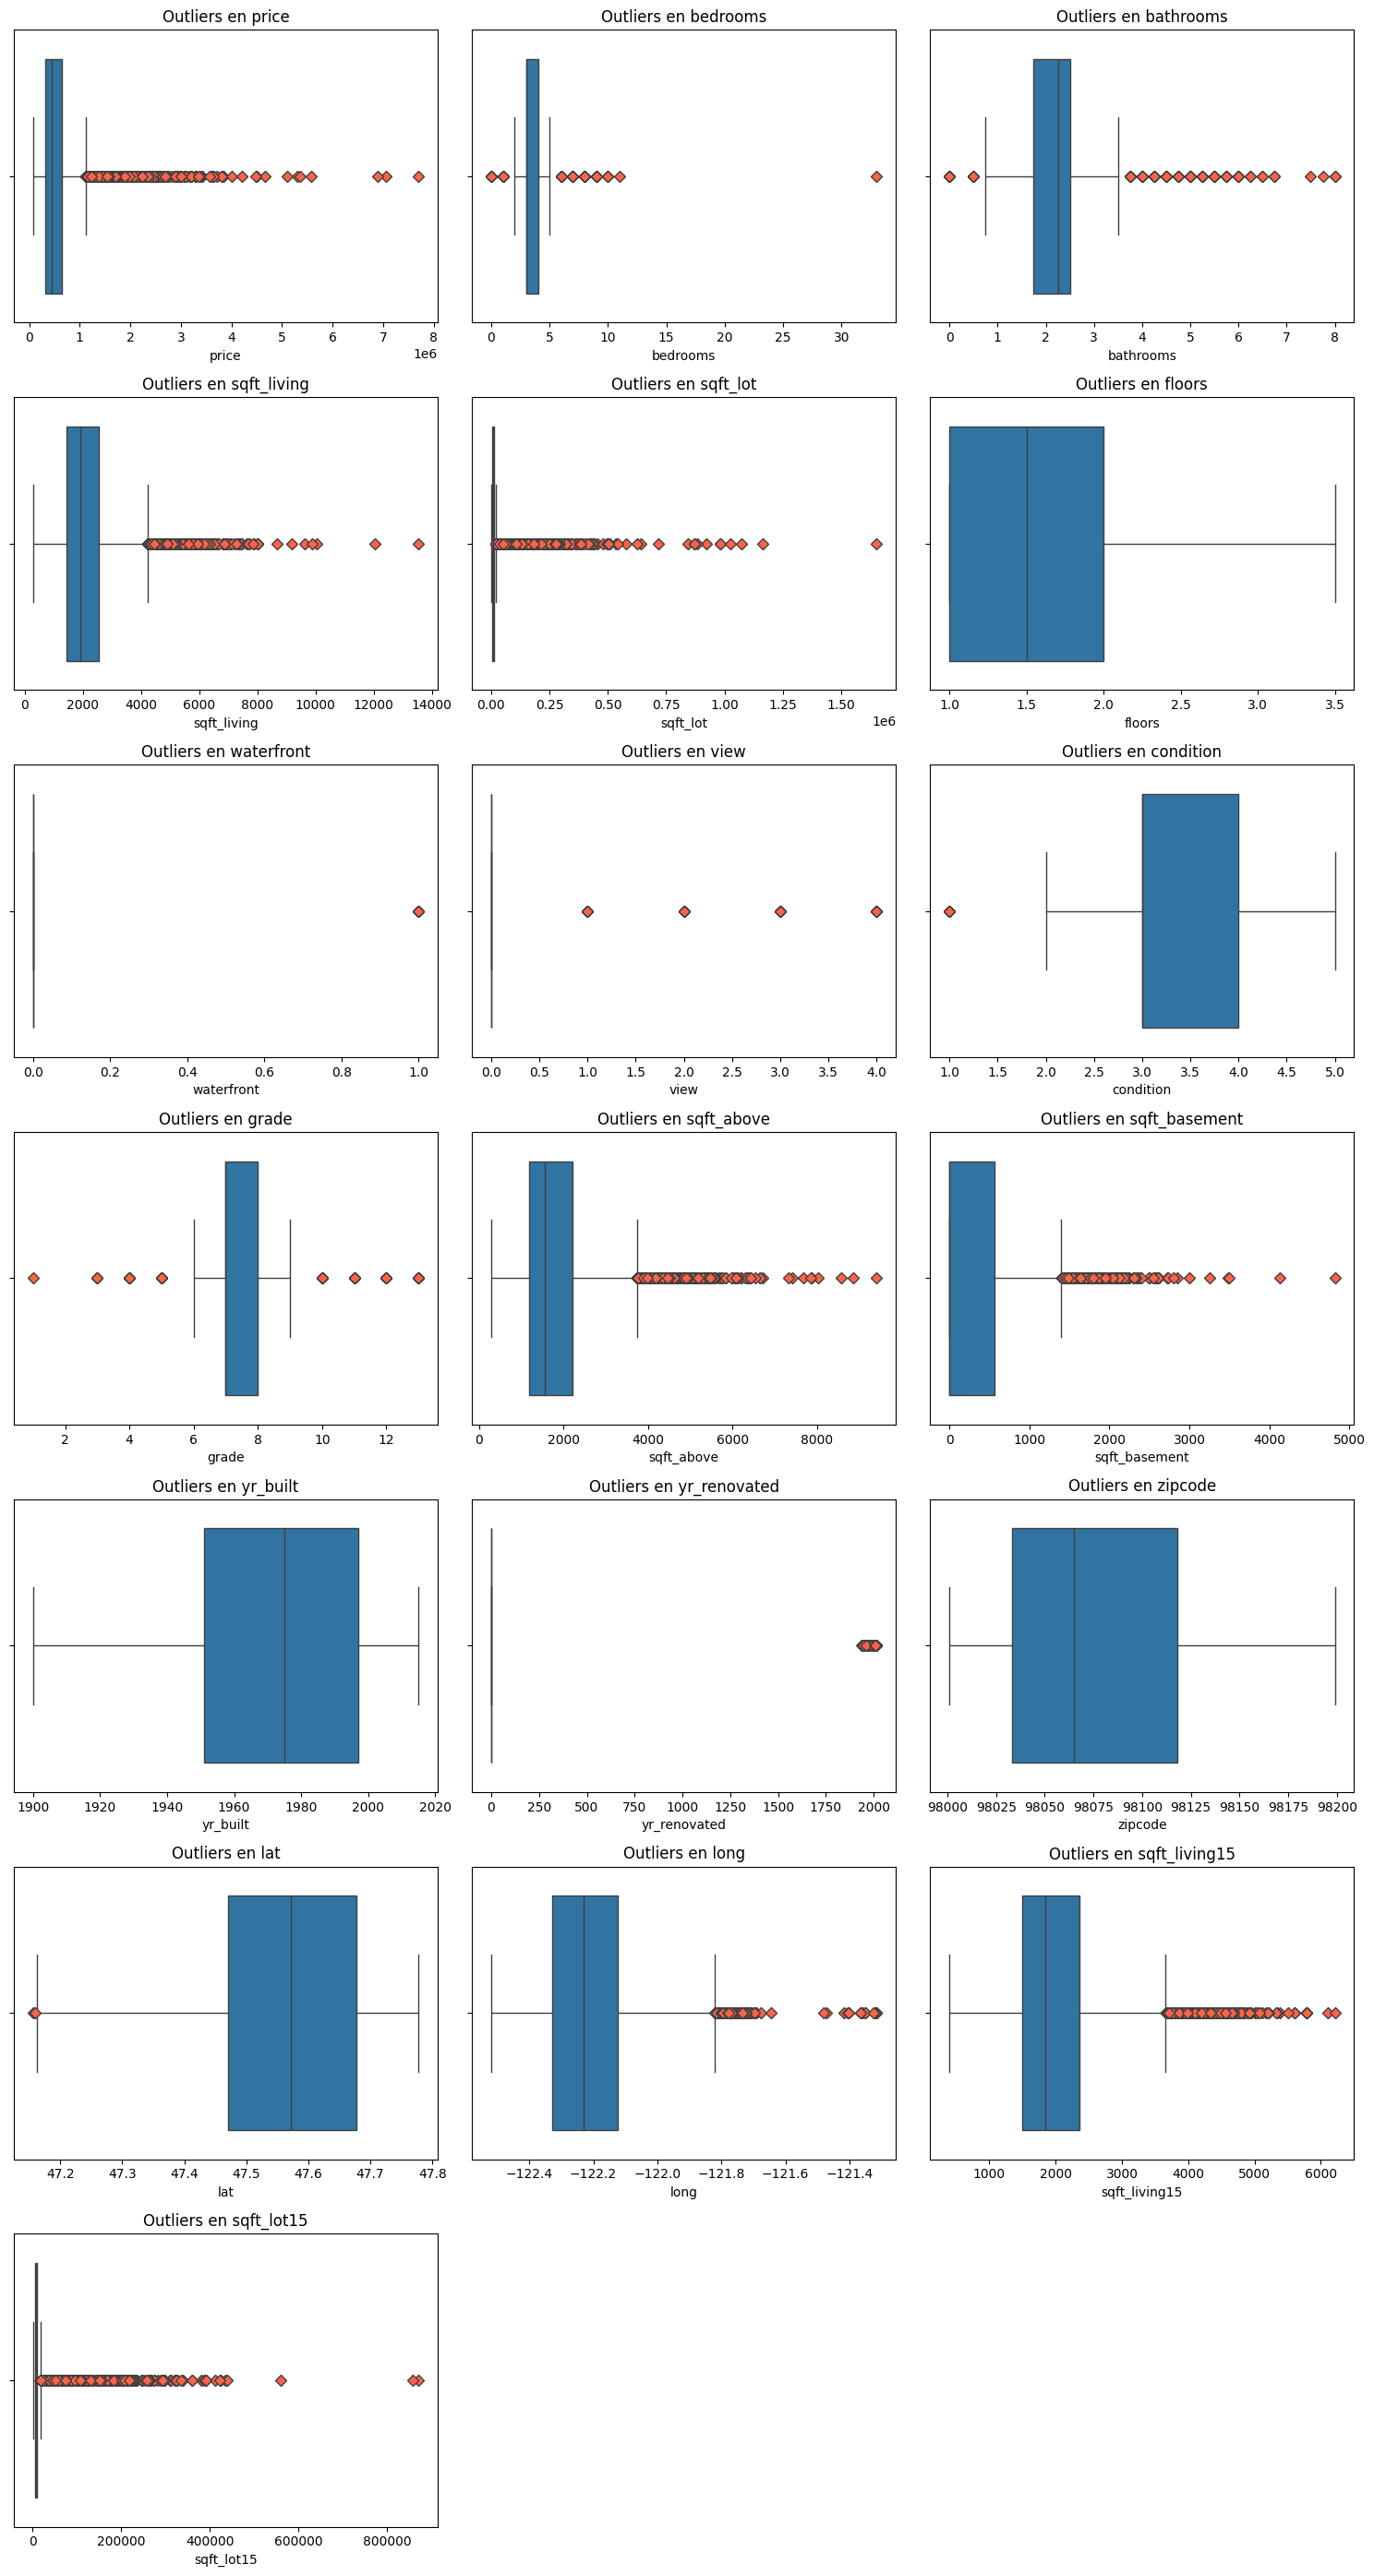

In [11]:
variables_numericas = df.select_dtypes(include=['float64', 'int64']).columns.to_list()
plot_outliers(df, variables_numericas)

> **Eliminación de outliers**
> - Para la eliminación de outliers se utiliza percentiles.
> - Se elimina los outliers de la derecha debido a que son datos positivos y evitar perder datos que pueden ser significativos.
> - Solo se eliminan aproximadamente 5% de los datos para no perder muchos datos. Para ello se utiliza el rango [0, 99.5] de los perceptiles.

Porcentaje de registros eliminados: 5.73%


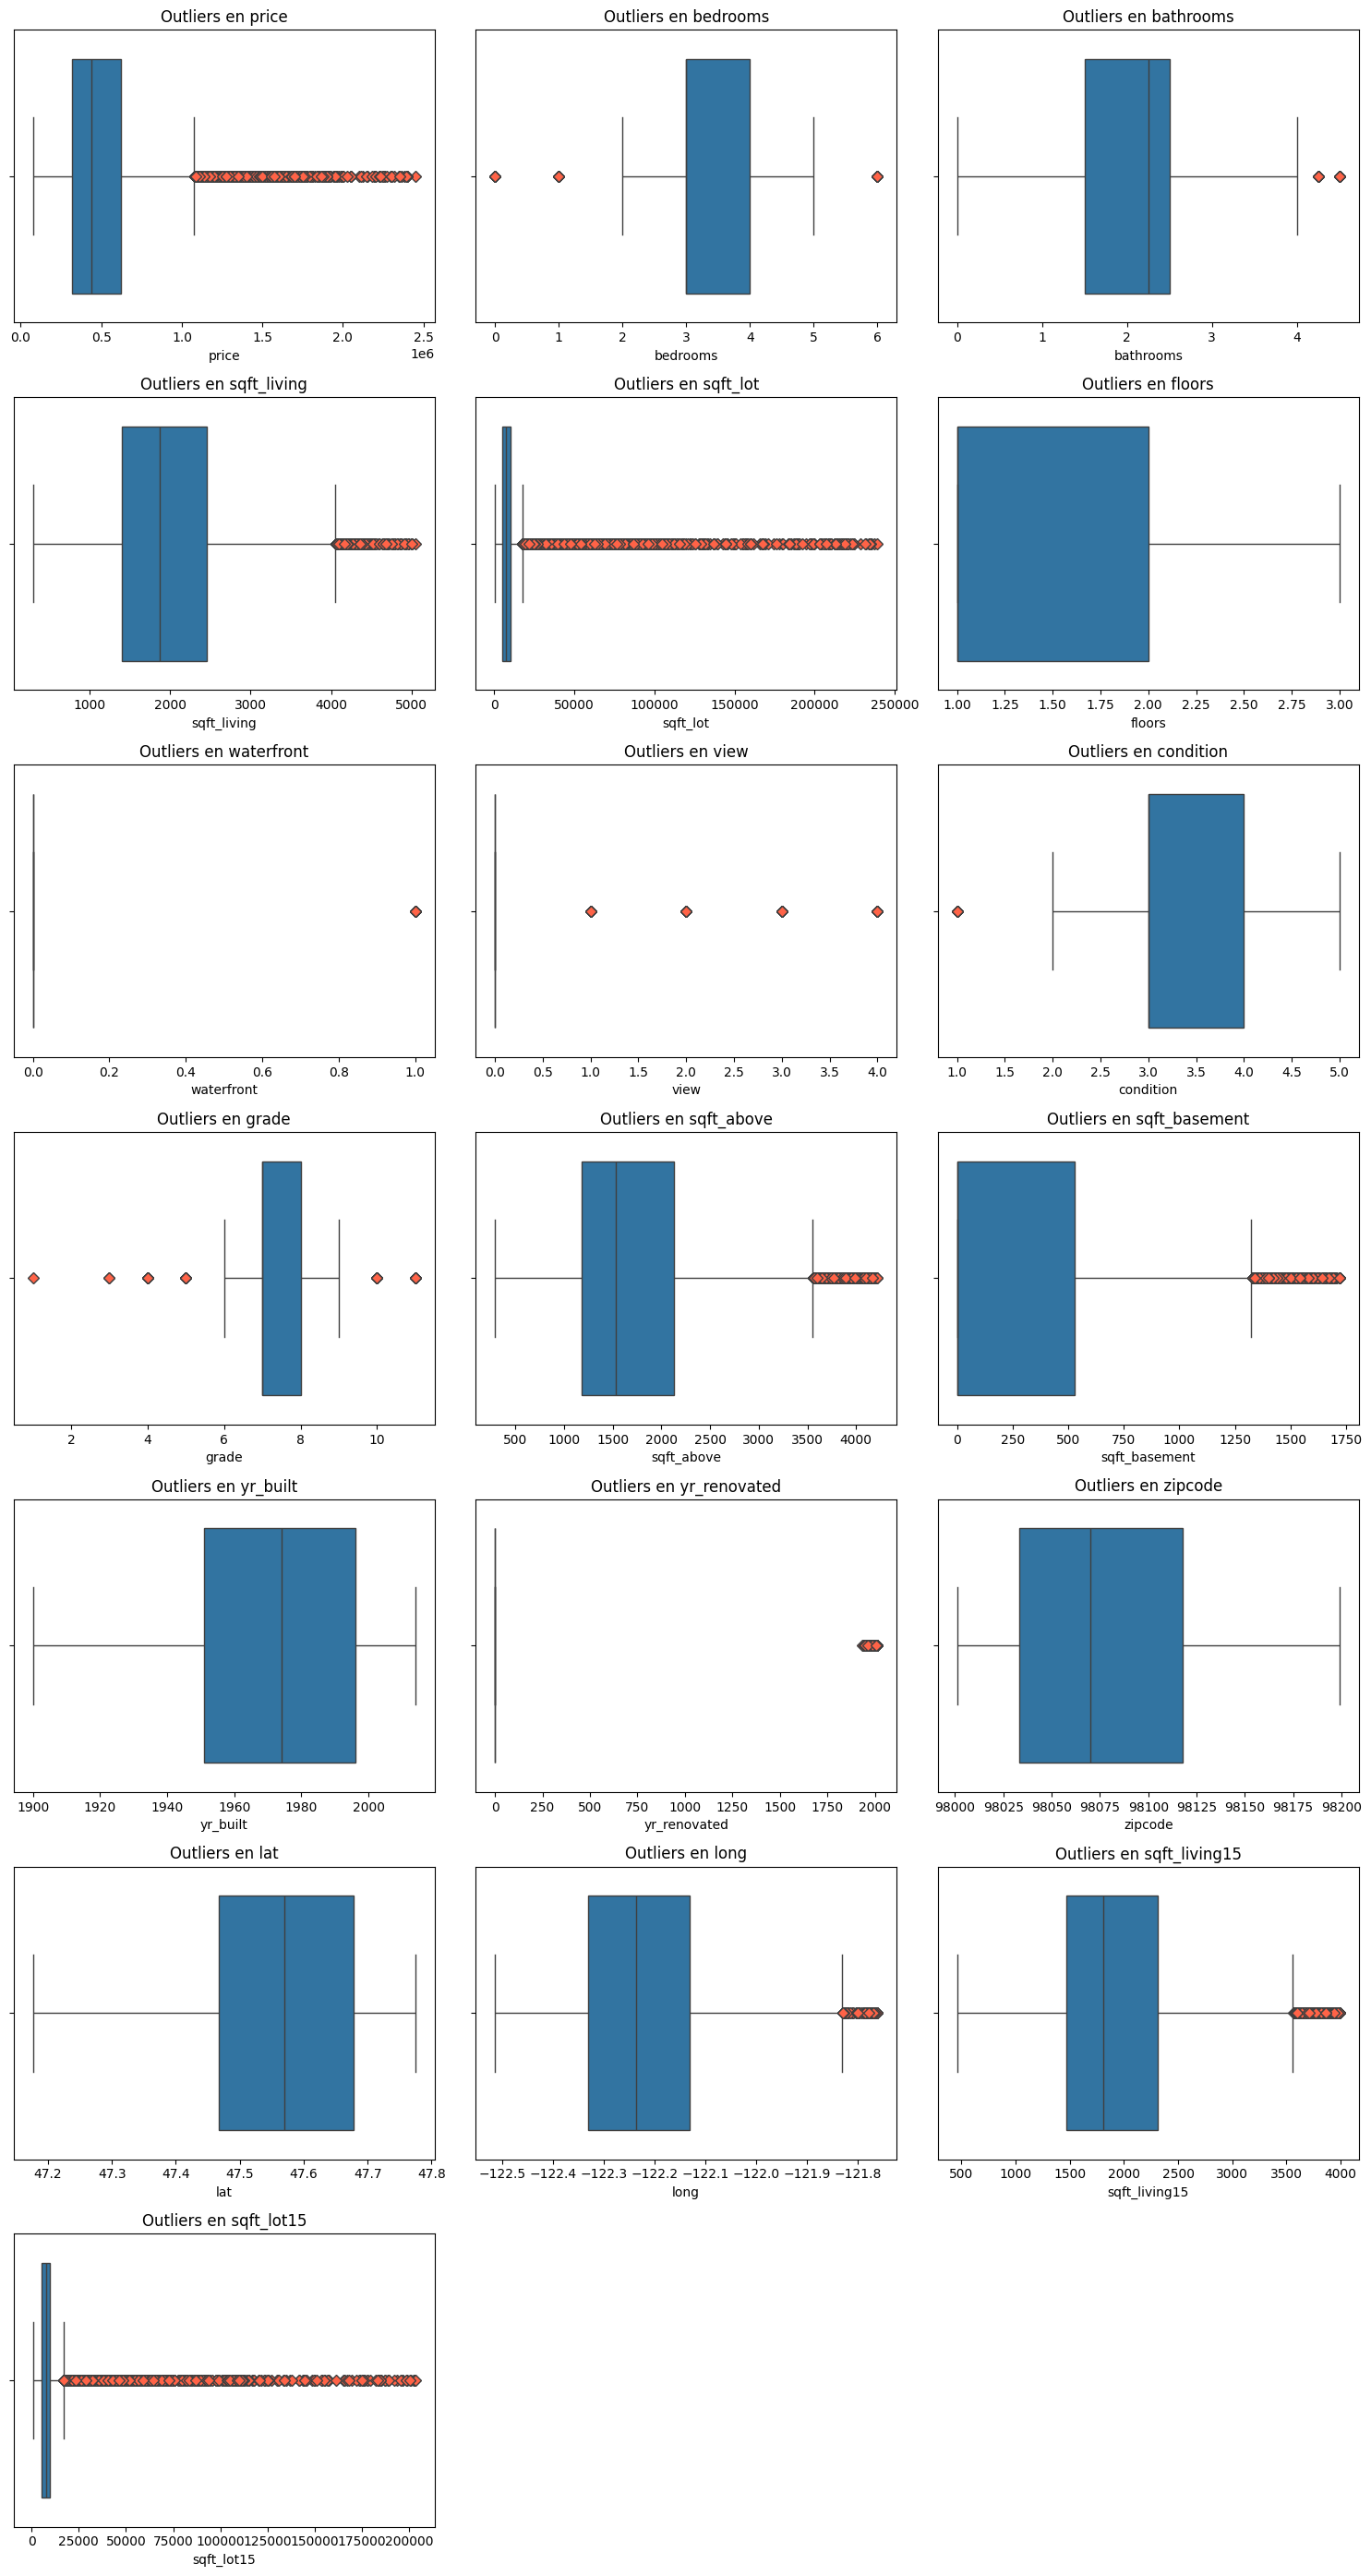

In [12]:
df_limpio = clean_outliers_percentiles(df, variables_numericas, 0, 99.5) # Solo se elimina los outliers de la derecha
print(f"Porcentaje de registros eliminados: {(1 - len(df_limpio)/len(df))*100:.2f}%")
plot_outliers(df_limpio, variables_numericas)

In [13]:
df_limpio.describe()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,20374,"20,374.00","20,374.00","20,374.00","20,374.00","20,374.00","20,374.00","20,374.00","20,374.00","20,374.00","20,374.00","20,374.00","20,374.00","20,374.00","20,374.00","20,374.00","20,374.00","20,374.00","20,374.00","20,374.00"
mean,2014-10-29 09:28:44.904290048,"505,788.17",3.33,2.06,"1,989.03","11,455.53",1.48,0.01,0.20,3.42,7.57,"1,717.69",271.34,"1,970.43",73.17,"98,078.87",47.56,-122.22,"1,935.20","10,290.59"
min,2014-05-02 00:00:00,"75,000.00",0.00,0.00,290.00,520.00,1.00,0.00,0.00,1.00,1.00,290.00,0.00,"1,900.00",0.00,"98,001.00",47.18,-122.52,460.00,651.00
25%,2014-07-22 00:00:00,"316,000.00",3.00,1.50,"1,400.00","5,000.00",1.00,0.00,0.00,3.00,7.00,"1,180.00",0.00,"1,951.00",0.00,"98,033.00",47.47,-122.33,"1,470.00","5,036.00"
50%,2014-10-16 00:00:00,"441,000.00",3.00,2.25,"1,870.00","7,480.00",1.00,0.00,0.00,3.00,7.00,"1,530.00",0.00,"1,974.00",0.00,"98,070.00",47.57,-122.24,"1,810.00","7,500.00"
75%,2015-02-18 00:00:00,"620,000.00",4.00,2.50,"2,460.00","10,180.50",2.00,0.00,0.00,4.00,8.00,"2,130.00",530.00,"1,996.00",0.00,"98,118.00",47.68,-122.13,"2,308.75","9,771.50"
max,2015-05-27 00:00:00,"2,450,000.00",6.00,4.50,"5,050.00","239,144.00",3.00,1.00,4.00,5.00,11.00,"4,220.00","1,720.00","2,014.00","2,013.00","98,199.00",47.77,-121.76,"3,990.00","203,425.00"
std,NaN,"275,977.53",0.86,0.71,770.89,"19,031.30",0.54,0.07,0.70,0.65,1.07,720.02,404.91,29.39,374.84,53.56,0.14,0.13,614.47,"14,628.76"


## 2. Análisis de Variables

Realizar un análisis descriptivo de las variables para entender la distribución de los datos y detectar posibles relaciones entre las características y los precios. En esto debes incluir un análisis de correlaciones entre las variables principalmente con el precio de las casas, comenta acerca de las variables con mayor correlación, ¿tienen sentido?

### Descripción de las variables

| Nº | Columna           | Tipo           | Descripción                                                 |
| -: | ----------------- | -------------- | ----------------------------------------------------------- |
|  0 | **date**          | datetime64[ns] | Fecha en que la casa fue vendida.                           |
|  1 | **price**         | int64          | Precio final de venta de la casa (USD).                     |
|  2 | **bedrooms**      | int64          | Número de dormitorios.                                      |
|  3 | **bathrooms**     | float64        | Número de baños (incluye fracciones: 1.5, 2.25, etc.).      |
|  4 | **sqft_living**   | int64          | Superficie habitable interior (pies²).                      |
|  5 | **sqft_lot**      | int64          | Superficie total del terreno (pies²).                       |
|  6 | **floors**        | float64        | Número de pisos o niveles de la casa.                       |
|  7 | **waterfront**    | int64          | 1 = casa con acceso/vista al agua; 0 = no.                  |
|  8 | **view**          | int64          | Calidad de la vista (escala 0–4).                           |
|  9 | **condition**     | int64          | Estado general de la casa (escala 1–5).                     |
| 10 | **grade**         | int64          | Calidad de construcción y materiales (escala 1–13).         |
| 11 | **sqft_above**    | int64          | Superficie sobre el nivel del suelo (pies²).                |
| 12 | **sqft_basement** | int64          | Superficie del sótano (pies²).                              |
| 13 | **yr_built**      | int64          | Año de construcción de la vivienda.                         |
| 14 | **yr_renovated**  | int64          | Año de la última renovación (0 = nunca renovada).           |
| 15 | **zipcode**       | int64          | Código postal de la zona donde se ubica la vivienda.        |
| 16 | **lat**           | float64        | Latitud de la propiedad.                                    |
| 17 | **long**          | float64        | Longitud de la propiedad.                                   |
| 18 | **sqft_living15** | int64          | Superficie habitable promedio de las 15 casas más cercanas. |
| 19 | **sqft_lot15**    | int64          | Tamaño promedio del terreno de las 15 casas más cercanas.   |


**Características estructurales**

* bedrooms, bathrooms: número de habitaciones y baños (enteros o fraccionarios).
* sqft_living, sqft_above, sqft_basement: superficies interiores.
* sqft_lot: superficie del terreno.
* floors: cantidad de pisos.

**Calidad, vista y ubicación**

* waterfront: vista/acceso al agua (binario).
* view: calidad de la vista (0–4).
* condition: estado general (1–5).
* grade: calidad de construcción y terminaciones (1–13).

**Temporalidad**

* date: fecha de venta.
* yr_built: año de construcción.
* yr_renovated: año de renovación (0 = nunca).

**Geolocalización**

* lat, long: coordenadas de la casa.
* zipcode: zona geográfica.

**Vecindario**

* sqft_living15: superficie habitable promedio dentro de 15 casas cercanas.
* sqft_lot15: superficie del terreno promedio dentro de 15 casas cercanas.

### Distribuciones

Para poder mostrar las distribuciones se realiza una división entre variables cuantitativas y cualitativas. Se descartan zipcode y date debido a que contienen muchas categorías.

In [14]:
# Variables cuantitativas (numéricas continuas o discretas)
variables_cuantitativas = [
    "price",
    "bedrooms",
    "bathrooms",
    "sqft_living",
    "sqft_lot",
    "floors",
    "sqft_above",
    "sqft_basement",
    "yr_built",
    "yr_renovated",
    "lat",
    "long",
    "sqft_living15",
    "sqft_lot15"
]

# Variables categóricas o cualitativas
variables_cualitativas = [
    # "date",        # puede tratarse como temporal, pero no como variable numérica directa
    "waterfront",  # binaria
    "view",        # ordinal
    "condition",   # ordinal
    "grade",       # ordinal
    # "zipcode"      # categórica nominal (zona geográfica)
]

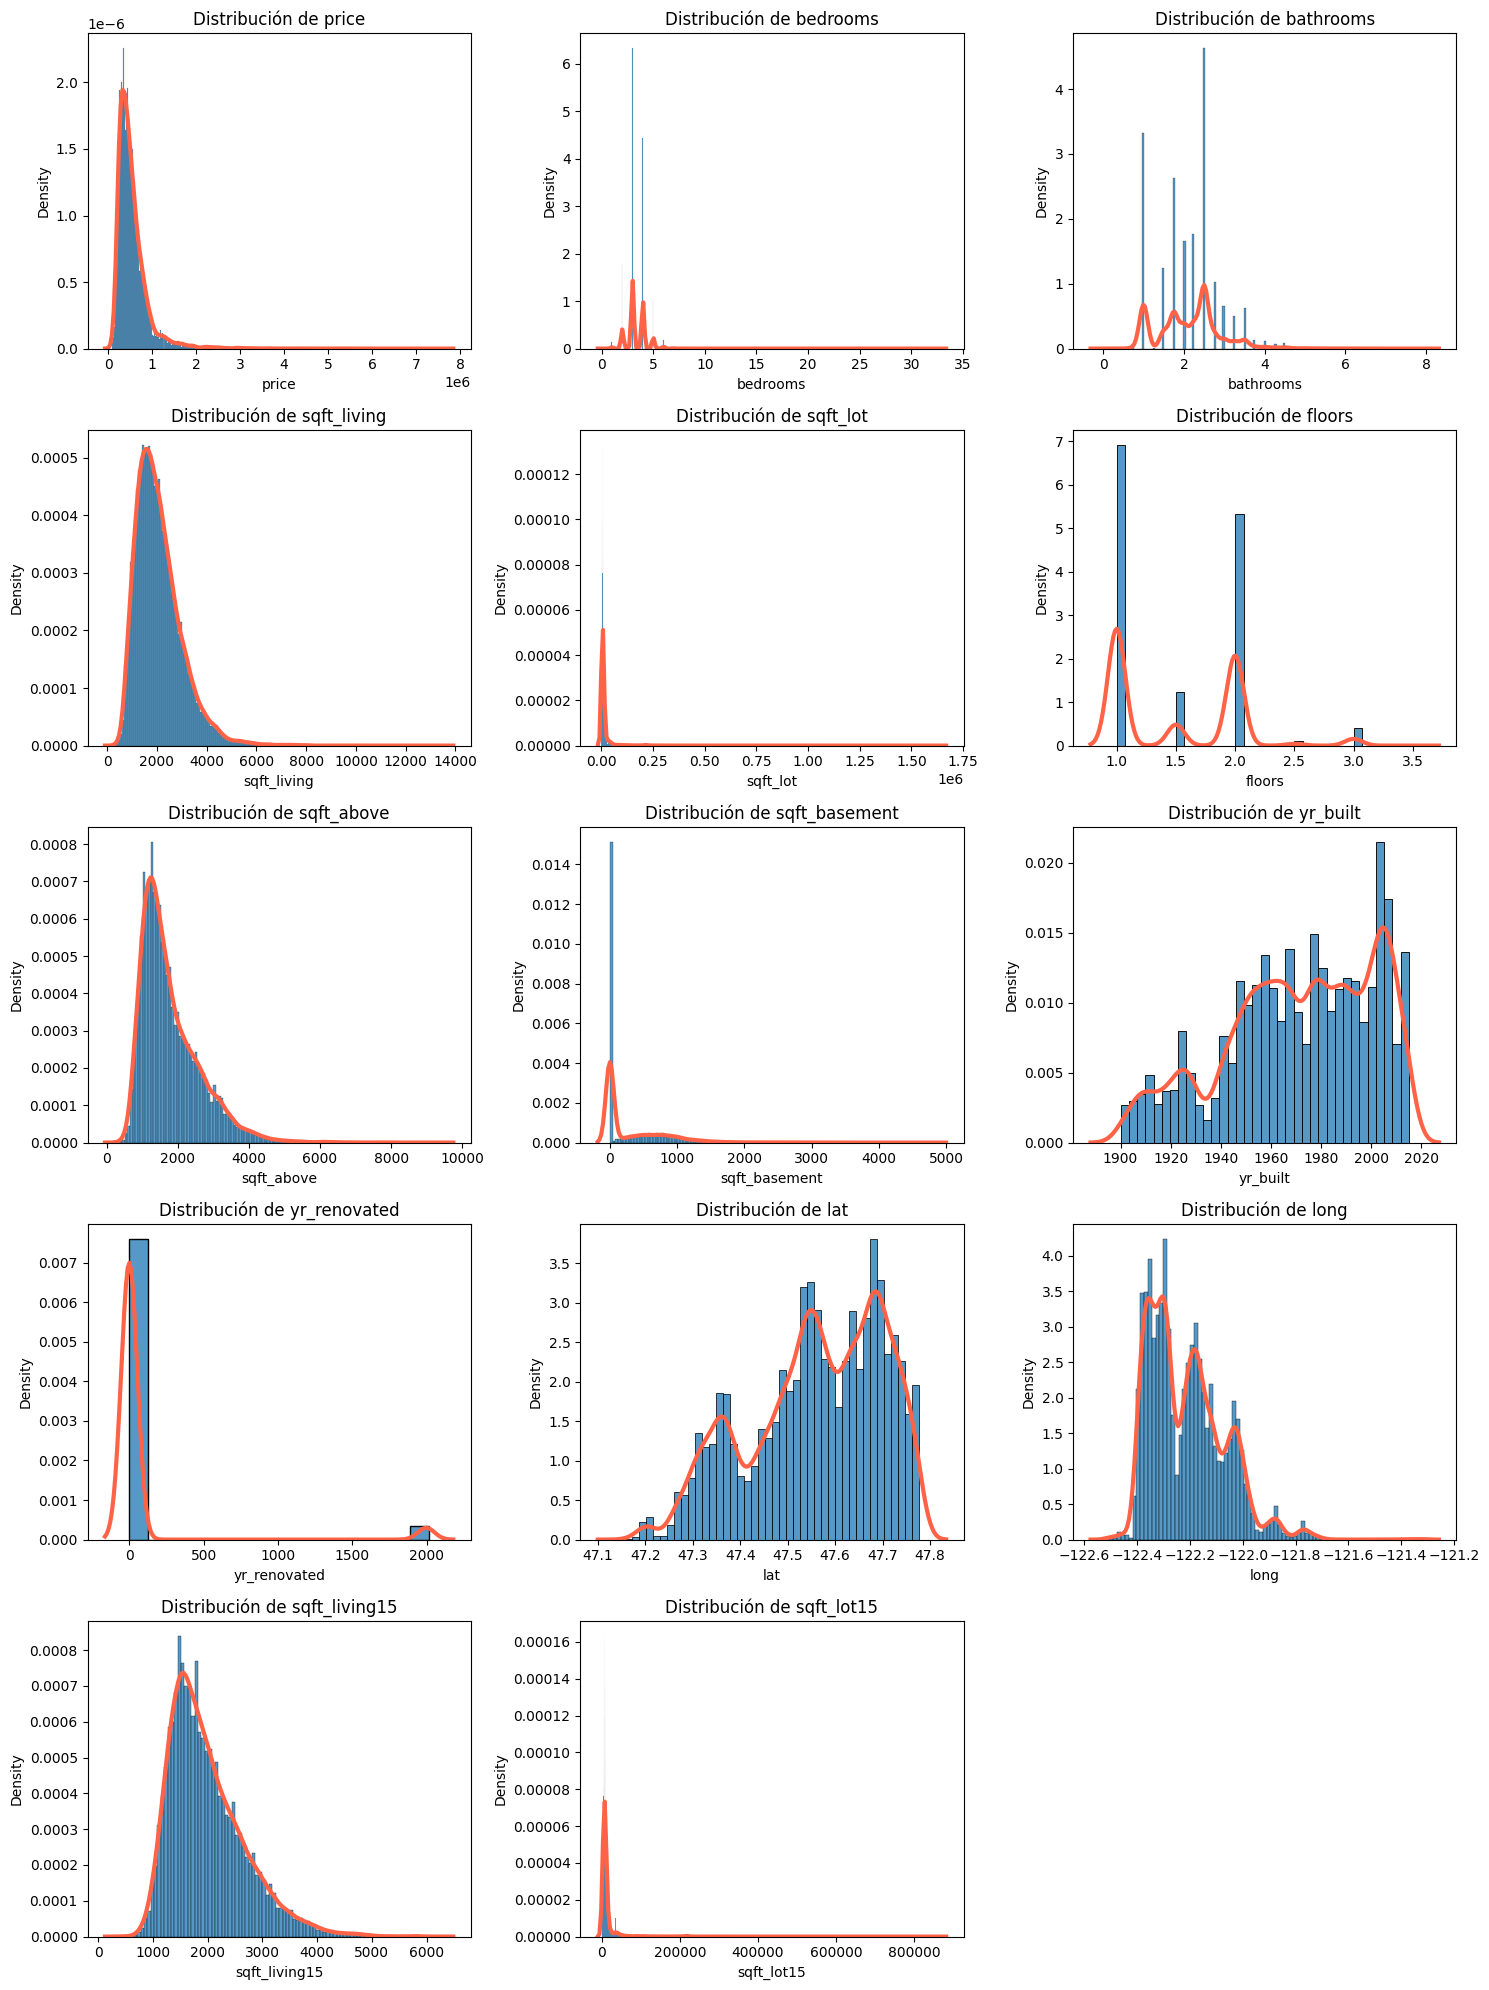

In [15]:
plot_hist(df, variables_cuantitativas)

> Variables cuantitativas
> - Casi todas las variables distribuyen centradas en su media con asimetría positiva debido a que no tienen valores negativos.
> - Las variables de latitud y longitud tiene multiples medias debido probablemente a que indica locaciones de asentamientos.
> - Existen variables como floor, bathroom, bedroom que se comportan como variables categóricas debido a que son discretas a pesar de ser guardadas como reales.   

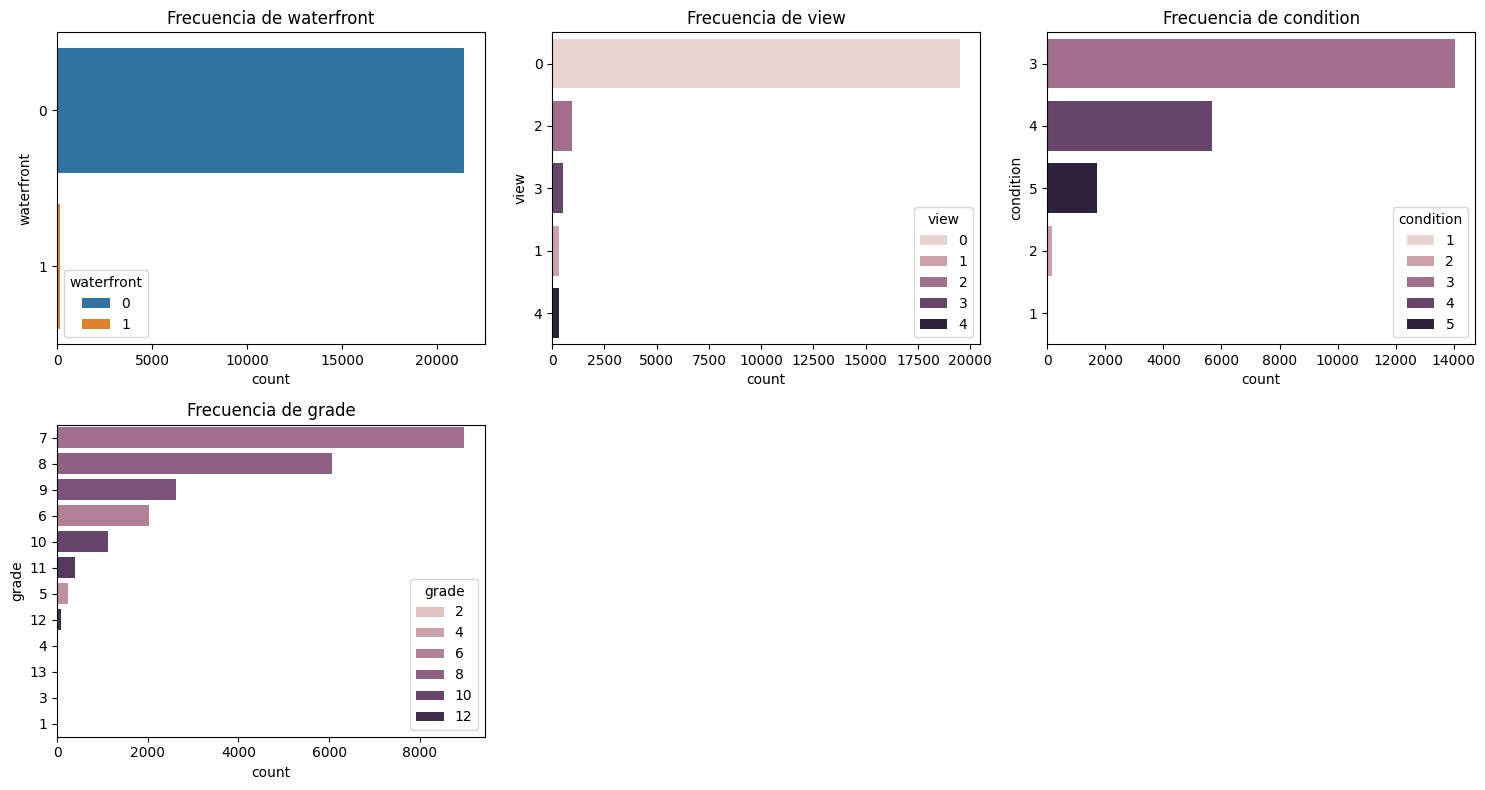

In [16]:
plot_count(df, variables_cualitativas)

### Correlación

In [17]:
# Antes de realizar el análisis de correlación se separará los datos de año, mes y día de la fecha
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month
df["day"] = df["date"].dt.day

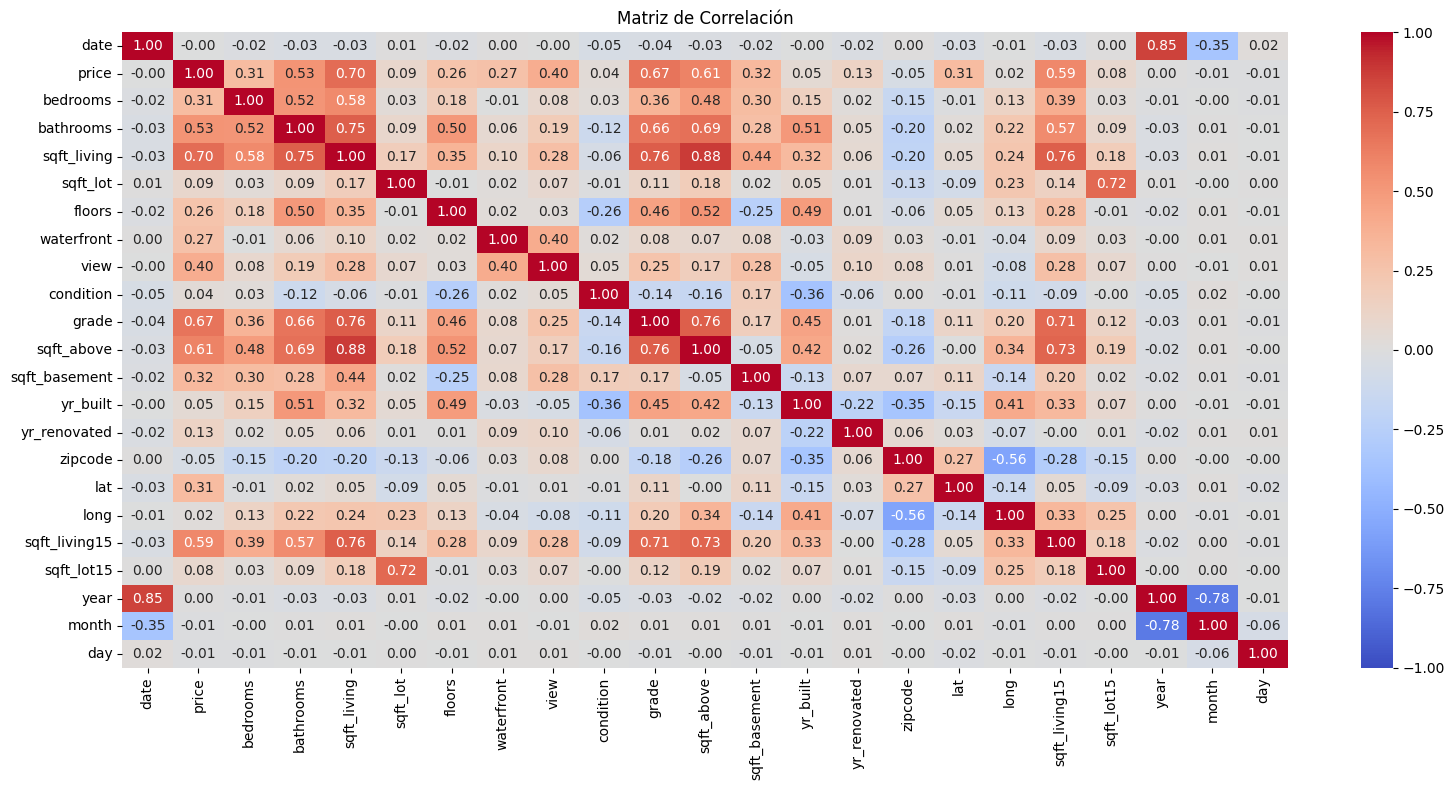

In [18]:
matriz_correlacion = df.corr()

plt.figure(figsize=(16, 8))

sns.heatmap(matriz_correlacion, annot=True, cmap="coolwarm", fmt=".2f",vmin=-1, vmax=1)
plt.title("Matriz de Correlación")

plt.tight_layout()
plt.show()

> Usando como criterio |correlación| > 0.5, las características más relevantes respecto al precio son:
>
> - sqft_living: 0.70
> - grade: 0.67
> - sqft_above: 0.61
> - sqft_living15: 0.59
> - bathrooms: 0.53
>
> Es decir, el precio está más fuertemente asociado con: el tamaño interior (sqft_living, sqft_above, sqft_living15),
> la calidad de la construcción (grade) y la cantidad de baños (bathrooms).
> Esto tiene sentido considerando las necesidades de las familias y que estos aspectos son básicos al momento de tasar una propiedad.

> Comentarios:
> - La fecha (date) no aporta mucho revisando la correlación con las demás variables incluso por separado, es decir, en año, mes y día.
> - Existen otras variables que no estan aportando mucho al precio |correlación| < 0.1

In [19]:
# Se eliminan las variables que no estan aportando mucho al precio |correlación| < 0.1
df = df.drop(["date", "year", "month", "day"], axis=1)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21613 non-null  int64  
 1   bedrooms       21613 non-null  int64  
 2   bathrooms      21613 non-null  float64
 3   sqft_living    21613 non-null  int64  
 4   sqft_lot       21613 non-null  int64  
 5   floors         21613 non-null  float64
 6   waterfront     21613 non-null  int64  
 7   view           21613 non-null  int64  
 8   condition      21613 non-null  int64  
 9   grade          21613 non-null  int64  
 10  sqft_above     21613 non-null  int64  
 11  sqft_basement  21613 non-null  int64  
 12  yr_built       21613 non-null  int64  
 13  yr_renovated   21613 non-null  int64  
 14  zipcode        21613 non-null  int64  
 15  lat            21613 non-null  float64
 16  long           21613 non-null  float64
 17  sqft_living15  21613 non-null  int64  
 18  sqft_l

## 3. Preparar conjunto de entrenamiento y prueba

Divide los datos en conjuntos de entrenamiento y prueba de manera aleatoria o estratificada, dejando un 33% para test, luego de eso aplica alguna técnica de transformación de datos, como normalización o estandarización, para asegurar que las variables estén en una escala comparable. (hint: Recuerda que en la estandarización o normalización de los datos el f it.transform solo se aplica a los datos de train, mientras que a los datos de test se les aplica solo el transform).

In [21]:
# División de los conjuntos de prueba y test
X = df.drop(['price'], axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [22]:
scaler = StandardScaler()

# fit solo en train
X_train = scaler.fit_transform(X_train)

# En test solo transform
X_test = scaler.transform(X_test)

## 4. Modelos de regresión

Implementar modelos de regresión lineal con regularización, como Ridge, Lasso y Elastic Net con ajuste de hiper parámetros, según tabla sugerida, debes construir además un modelo de árboles de regresión para capturar relaciones no lineales y complejas entre las variables predictoras y el precio de las casas, finalmente genera un cuadro comparativo con modelos y métricas.


In [23]:
# ==========================================
# Definición de modelos y grids de hiperparámetros
# ==========================================

lasso_params = {"alpha": [0.001, 0.01, 0.1, 1, 10]}
ridge_params = {"alpha": [0.001, 0.01, 0.1, 1, 10]}
elastic_params = {
    "alpha": [0.001, 0.01, 0.1, 1, 10],
    "l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9]
}
tree_params = {
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

modelos = {
    "Ridge": (Ridge(), ridge_params),
    "Lasso": (Lasso(max_iter=10000), lasso_params),
    "ElasticNet": (ElasticNet(max_iter=10000), elastic_params),
    "DecisionTree": (DecisionTreeRegressor(random_state=42), tree_params)
}

In [24]:
# ==========================================
# Búsqueda de hiperparámetros + evaluación
# ==========================================

resultados = []

for nombre_modelo, (estimator, param_grid) in modelos.items():
    print(f"\nEntrenando {nombre_modelo}...")

    grid = GridSearchCV(
        estimator=estimator,
        param_grid=param_grid,
        cv=5,
        scoring="neg_root_mean_squared_error",  # minimizamos RMSE
        n_jobs=-1
    )

    grid.fit(X_train, y_train)

    best_model = grid.best_estimator_
    best_params = grid.best_params_

    # Predicciones en test
    y_pred = best_model.predict(X_test)

    # Métricas
    mse = mean_squared_error(y_test, y_pred)
    rmse = mse ** 0.5
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    resultados.append({
        "modelo": nombre_modelo,
        "MSE_test": mse,
        "RMSE_test": rmse,
        "MAE_test": mae,
        "R2_test": r2,
        "mejores_hiperparametros": best_params
    })


Entrenando Ridge...

Entrenando Lasso...

Entrenando ElasticNet...

Entrenando DecisionTree...


In [25]:
# ==========================================
# Cuadro comparativo de modelos y métricas
# ==========================================

resultados_df = pd.DataFrame(resultados).set_index("modelo")

# Ordenar por RMSE ascendente (mejor modelo primero)
resultados_df = resultados_df.sort_values("MSE_test")

print("\n=== Resultados comparativos ===")
print(resultados_df)


=== Resultados comparativos ===
                      MSE_test  RMSE_test   MAE_test  R2_test  \
modelo                                                          
DecisionTree 30,073,936,112.00 173,418.38  91,918.90     0.80   
Lasso        45,427,385,256.19 213,137.01 126,904.74     0.70   
Ridge        45,430,580,781.90 213,144.51 126,887.92     0.70   
ElasticNet   45,459,609,338.52 213,212.59 126,762.21     0.70   

                                        mejores_hiperparametros  
modelo                                                           
DecisionTree  {'max_depth': 10, 'min_samples_leaf': 4, 'min_...  
Lasso                                             {'alpha': 10}  
Ridge                                             {'alpha': 10}  
ElasticNet                     {'alpha': 0.01, 'l1_ratio': 0.5}  


## 5. Seleccionar modelo

Elige uno de los modelos de regresión lineal con regularización implementados en el punto anterior y gráfica cómo varían sus hiperparámetros durante el ajuste, mostrando también cómo afectan el rendimiento del modelo.

> Se selecciona el modelo de Árbol de Decisión porque mejor comportamiento presenta (Menor MSE)

In [26]:
# ================================================
# Entrenar modelo para obtener info entrenamiento
# ================================================

tree = DecisionTreeRegressor(random_state=42)

grid_tree = GridSearchCV(
    estimator=tree,
    param_grid=tree_params,
    cv=5,
    scoring="neg_mean_squared_error",  # usamos MSE
    n_jobs=-1
)

grid_tree.fit(X_train, y_train)

print("Mejores hiperparámetros:", grid_tree.best_params_)
print("Mejor score (MSE cv):", (-grid_tree.best_score_))

Mejores hiperparámetros: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}
Mejor score (MSE cv): 25938522512.256813


> Importancia de las variables en el modelo

In [31]:
# ================================================
# importancia de variables en el modelo
# ================================================

best_tree = grid_tree.best_estimator_

importances = best_tree.feature_importances_
feature_names = df.drop(['price'], axis=1).columns.to_list()

feat_importance = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
})

feat_importance = feat_importance.sort_values("importance", ascending=False)

print(feat_importance)

          feature  importance
8           grade        0.40
2     sqft_living        0.25
14            lat        0.15
15           long        0.06
5      waterfront        0.03
11       yr_built        0.03
16  sqft_living15        0.02
6            view        0.01
13        zipcode        0.01
17     sqft_lot15        0.01
9      sqft_above        0.01
3        sqft_lot        0.00
1       bathrooms        0.00
10  sqft_basement        0.00
7       condition        0.00
4          floors        0.00
12   yr_renovated        0.00
0        bedrooms        0.00


> Para este modelo existen variables importantes que no fueron visualizadas en el análisis de correlación por ejemplo lat, long y waterfront y yr_built. Por otro lado, si aparece grade con una importancia importante de 0.40.

> Obtener la información del entrenamiento

In [28]:
# ================================================
# Extraer info entrenamiento
# ================================================
cv_results_tree = pd.DataFrame(grid_tree.cv_results_)

cv_tree_small = cv_results_tree[[
    "param_max_depth",
    "param_min_samples_split",
    "param_min_samples_leaf",
    "mean_test_score"
]].copy()

# mean_test_score es MSE
cv_tree_small["RMSE_cv"] = (-cv_tree_small["mean_test_score"]) ** 0.5

cv_tree_small.head()

,param_max_depth,param_min_samples_split,param_min_samples_leaf,mean_test_score,RMSE_cv
0,None,2,1,"-30,719,504,722.27","175,269.81"
1,None,5,1,"-30,130,263,176.32","173,580.71"
2,None,10,1,"-28,481,651,307.70","168,765.08"
3,None,2,2,"-30,202,135,361.43","173,787.62"
4,None,5,2,"-29,550,123,052.72","171,901.49"


#### Gráficar RMSE vs max_depth para distintos min_samples_leaf

Para simplificar se fija min_samples_split = 2 y se gráfica el efecto de max_depth y min_samples_leaf.

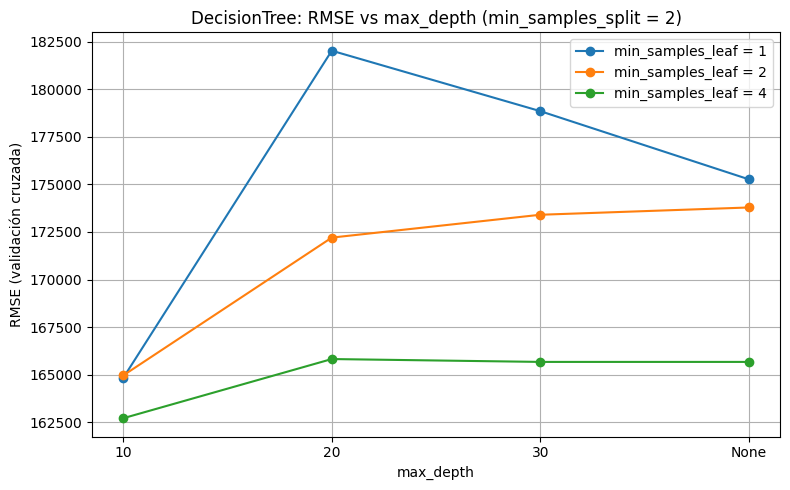

In [29]:
plt.figure(figsize=(8, 5))

# Se fija min_samples_split = 2
base_split = 2
mask_split = cv_tree_small["param_min_samples_split"] == base_split
subset_split = cv_tree_small[mask_split]

for leaf in sorted(subset_split["param_min_samples_leaf"].unique()):
    mask_leaf = subset_split["param_min_samples_leaf"] == leaf
    subset = subset_split[mask_leaf].copy()

    # Se ordena por max_depth
    subset = subset.sort_values("param_max_depth", key=lambda s: s.map(lambda v: 999 if v is None else v))

    # Reemplazamos None por un valor de texto para mostrar en el eje
    x_vals = subset["param_max_depth"].astype(str)
    y_vals = subset["RMSE_cv"]

    plt.plot(x_vals, y_vals, marker="o", label=f"min_samples_leaf = {leaf}")

plt.xlabel("max_depth")
plt.ylabel("RMSE (validación cruzada)")
plt.title("DecisionTree: RMSE vs max_depth (min_samples_split = 2)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

> Enb el gráfico anterior RMSE menor es mejor. Se puede concluir que con un max_depth de 10 y un min_samples_leaf de 4 es suficiente para alcanzar un buen rendimiento. Generar un árbol más profundo no mejora los resultados y se puede sobreentrenar el modelo.

#### Gráficar max_depth vs min_samples_split (para un min_samples_leaf fijo)

Para simplificar se fija min_samples_leaf = 1 y se gráfica max_depth y min_samples_split.

param_max_depth                 10         20         30
param_min_samples_split                                 
2                       162,708.62 165,819.02 165,668.33
5                       162,708.62 165,819.02 165,668.33
10                      161,054.41 163,452.96 163,751.48


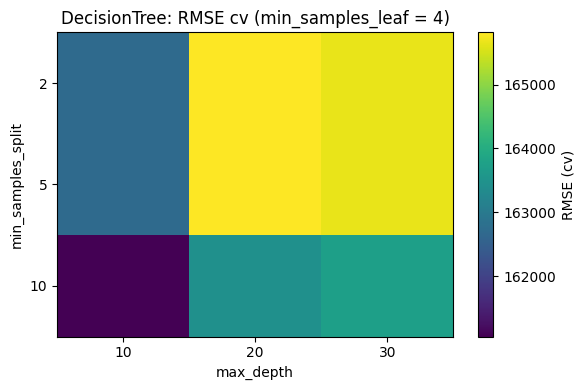

In [32]:
leaf_fixed = 4
mask_leaf = cv_tree_small["param_min_samples_leaf"] == leaf_fixed
subset_leaf = cv_tree_small[mask_leaf]

pivot_rmse = subset_leaf.pivot_table(
    index="param_min_samples_split",
    columns="param_max_depth",
    values="RMSE_cv"
)

print(pivot_rmse)

plt.figure(figsize=(6, 4))
plt.imshow(pivot_rmse, aspect="auto")
plt.colorbar(label="RMSE (cv)")
plt.xticks(range(len(pivot_rmse.columns)), pivot_rmse.columns)
plt.yticks(range(len(pivot_rmse.index)), pivot_rmse.index)
plt.xlabel("max_depth")
plt.ylabel("min_samples_split")
plt.title(f"DecisionTree: RMSE cv (min_samples_leaf = {leaf_fixed})")
plt.tight_layout()
plt.show()

> Se puede ver claramente que con un min_samples_split de 10 se obtiene el mejor resultado.

## 6. Evaluación

Utilizar métricas de evaluación de regresión, como el Error Cuadrático Medio (MSE), el Error Absoluto Medio (MAE) y el Coeficiente de Determinación (R²), para medir el rendimiento del modelo, realizar cuadro comparativo indicado en el punto 4, finaliza con una breve conclusión de a los resultados obtenidos.

In [33]:
print("\n=== Resultados comparativos ===")
print(resultados_df)


=== Resultados comparativos ===
                      MSE_test  RMSE_test   MAE_test  R2_test  \
modelo                                                          
DecisionTree 30,073,936,112.00 173,418.38  91,918.90     0.80   
Lasso        45,427,385,256.19 213,137.01 126,904.74     0.70   
Ridge        45,430,580,781.90 213,144.51 126,887.92     0.70   
ElasticNet   45,459,609,338.52 213,212.59 126,762.21     0.70   

                                        mejores_hiperparametros  
modelo                                                           
DecisionTree  {'max_depth': 10, 'min_samples_leaf': 4, 'min_...  
Lasso                                             {'alpha': 10}  
Ridge                                             {'alpha': 10}  
ElasticNet                     {'alpha': 0.01, 'l1_ratio': 0.5}  


> **Conclusión**
>
> El Decision Tree o árbol de decisión con fuerte regularización (max_depth=10, min_samples_leaf=4) es claramente el mejor modelo, logrando el menor error (RMSE ≈ 173k) y el mayor poder explicativo (R² = 0.80).
Los modelos de regresión lineal regularizados (Lasso, Ridge y ElasticNet) tienen un desempeño muy similar entre sí (RMSE ≈ 213k, R² ≈ 0.70) y quedan por debajo del árbol, mostrando que la relación entre las variables y el precio no es completamente lineal, y que un modelo no lineal captura mejor la estructura de los datos.